<a href="https://colab.research.google.com/github/GabriellaHrymajlo/GEOG5990_201400859_FinalProject/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **What is the association between public transport accessibility and employment rates in Manchester?**



This project investigates whether areas with better public transport accessibility in Greater Manchester have higher employment rates. Using 2011 Census data, we explore the association between commuting distances, travel modes, and employment outcomes at the MSOA level. Locations of bus stops are also used to give insights.  The main goal is to investigate whether areas where a higher proportion of residents commute by public transport also have higher employment levels. Understanding this relationship can support evidence-based decision-making in transport planning and employment policy. The project follows a full data science workflow and includes spatial and non-spatial visualisations, along with reproducible code and documentation.


In [ ]:
# Import Required Libraries and Packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install contextily
import contextily as ctx
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.3 MB/s eta 0:00:00


**1.0 Data Exploration and Cleaning**

**1.1 Exploring Boundary Data**

In [98]:
# Load Manchester boundaries
mancboundaries = gpd.read_file("england_msoa_2011.shp")

In [99]:
# Check the first few rows to verify columns and structure
mancboundaries.head()

,code,name,label,geometry
0,E02001045,Manchester 001,E08000003E02001045,"POLYGON ((385672.188 405140, 385671.004 405128..."
1,E02001046,Manchester 002,E08000003E02001046,"POLYGON ((386609.567 403992.776, 386626.093 40..."
2,E02001047,Manchester 003,E08000003E02001047,"POLYGON ((387164.548 403916.823, 387167.731 40..."
3,E02001048,Manchester 004,E08000003E02001048,"POLYGON ((384278.241 404726.991, 384292.688 40..."
4,E02001049,Manchester 005,E08000003E02001049,"POLYGON ((388361.484 402967.194, 388362 402967..."


In [100]:
# Check the CRS
print("CRS:", mancboundaries.crs)

CRS: EPSG:27700


In [101]:
# Confirm MSOA codes are present - for spatial data joining later
print("Columns:", mancboundaries.columns)

Columns: Index(['code', 'name', 'label', 'geometry'], dtype='object')


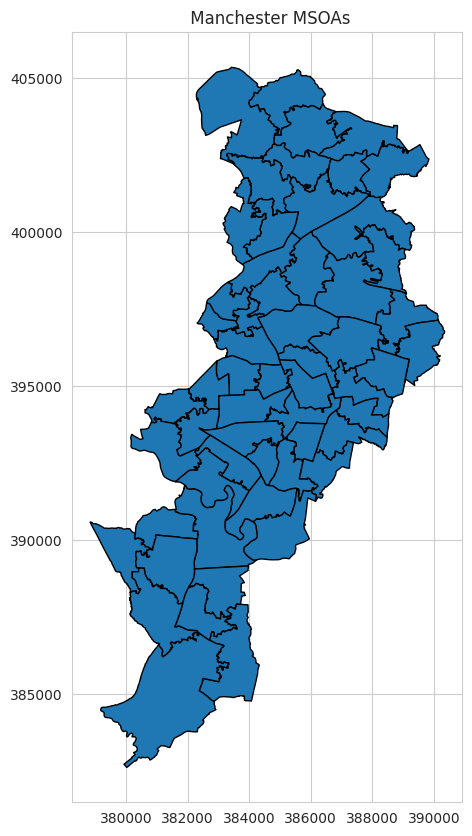

In [102]:
# Plot a basic map of Manchester MSOAs
mancboundaries.plot(edgecolor='black', figsize=(10, 10)) # Plotting the dataset. Defining size and setting boundary lines to black.
plt.title(" Manchester MSOAs") # Give the plot a title
plt.show() # Show the plot


**1.2 Exploring Bus Stop Data**

In [119]:
# Load in bus stop data
busstops_df = pd.read_csv("TfGMStoppingPoints.csv")

# Contains Transport for Greater Manchester data. Contains OS data © Crown copyright and database right 2024.

In [120]:
# Check the first few rows to see structure
busstops_df.head()

,AtcoCode,Easting,Northing,Longitude,Latitude,StopType,BusStopType
0,1800WKH4032,356697,410685,-2.655676,53.59095,BCT,HAR
1,1800SBT0641,384219,398501,-2.239274,53.48299,TXR,NaN
2,1800SBT0351,383740,397932,-2.246462,53.47786,TXR,NaN
3,1800SG44991,385992,386275,-2.212008,53.37315,BCT,MKD
4,1800SGH2781,386832,384681,-2.199316,53.35884,BCT,HAR


In [121]:
# Print all column names in a DataFrame
print(busstops_df.columns)

Index(['AtcoCode', 'Easting', 'Northing', 'Longitude', 'Latitude', 'StopType',
       'BusStopType'],
      dtype='object')


In [174]:
# As you can see above 'busstops_df' has longitude and latitude, but to be able
# to be able to be plotted, the busstops_df needs to be converted to a GeoDataFrame

# Convert the DataFrame to a GeoDataFrame with specified geometry
busstops_df = gpd.GeoDataFrame(
    busstops_df,  # Existing DataFrame containing bus stop information
    geometry=gpd.points_from_xy(busstops_df["Longitude"], busstops_df["Latitude"])
    # Creates a 'geometry' column using Longitude & Latitude values
    # Converts each (Longitude, Latitude) pair into a spatial Point object
)

# Assign CRS if missing (WGS84 - EPSG:4326)
if busstops_df.crs is None:  # Checks if the GeoDataFrame has a Coordinate Reference System (CRS)
    busstops_df.set_crs(epsg=4326, inplace=True)  # Assigns WGS84

# Convert to British National Grid (EPSG:27700)
busstops_df = busstops_df.to_crs(epsg=27700)
# Converts coordinates from WGS84 to British National Grid, needed for operations with UK based
# Spatial data sets like 'mancboundaries'


Transforming coordinate systems ensures bus stop locations align correctly with Manchester MSOA boundaries, allowing accurate spatial analysis. Initially, busstops_df stores longitude and latitude values, which must be converted into a GeoDataFrame to enable geospatial operations. Since these coordinates are typically stored in EPSG:4326 (WGS84)—a global geographic CRS that represents locations in degrees—this system is unsuitable for precise spatial measurements in the UK. Therefore, if the CRS is missing, EPSG:4326 is explicitly assigned to maintain data consistency. However, to ensure compatibility with UK spatial datasets, including mancboundaries, the data is converted to EPSG:27700. This transformation prevents misalignment when conducting spatial joins or distance-based analysis and is a standard approach in UK geospatial research (Oyana, 2020).

In [123]:
# After the conversion check the CRS of bus stops and boundaries match
print(busstops_df.crs)  # Check CRS of bus stops
print(mancboundaries.crs)  # Check CRS of Manchester boundaries

EPSG:27700
EPSG:27700


In [124]:
# Clip bus stops to fit within Manchester boundaries
busstops_cropped = gpd.clip(busstops_df, mancboundaries)

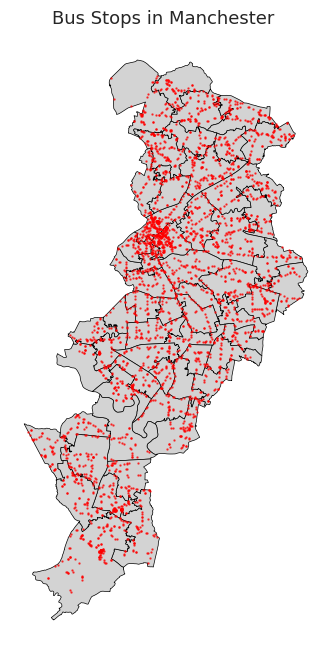

In [175]:
# Plot the cropped bus stops on a map of manchester boundaries

# Plot the cropped bus stops
fig, ax = plt.subplots(figsize=(12, 8)) # Define plot size
mancboundaries.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5) # Plotting mancboundaries. Grey fill and black outline.
busstops_cropped.plot(ax=ax, color="red", markersize=0.5, alpha=0.7) # Plotting the bus stops with red marker so visible and also small
# marker size as there are many points for visibility and readability purposes

# Customise visualisation
plt.title("Bus Stops in Manchester ", fontsize=13) #Meaningful title and appropriate font size for title.
plt.axis("off") # No axis for clean visulisation

plt.show() # Show the plot


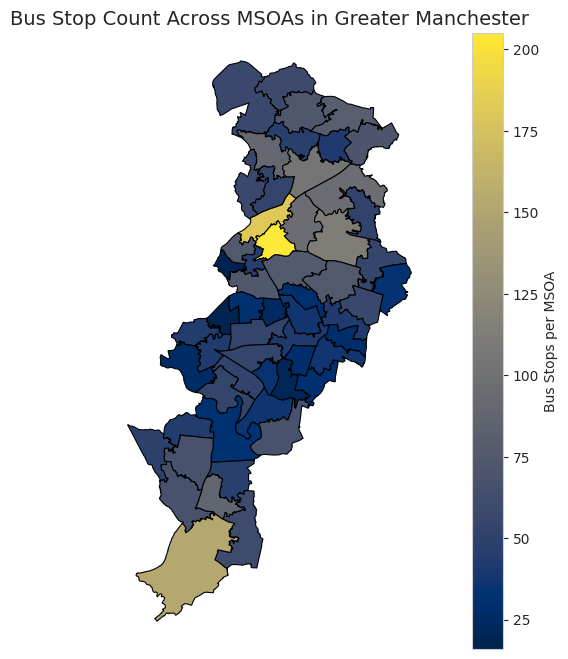

In [128]:
# Spatially join the bus stop data with Manchester MSOA boundaries
# and count how many bus stops are within each MSOA.

# Perform a spatial join to associate each bus stop with the MSOA it falls within
bus_stop_counts = gpd.sjoin(
    busstops_df,  # GeoDataFrame containing bus stop locations
    mancboundaries,  # GeoDataFrame with MSOA boundaries
    how="inner",  # Keeps only bus stops that fall within an MSOA
    predicate="within"  # Checks if each bus stop is inside an MSOA
).groupby("code").size().reset_index(name="Bus_Stop_Count")
# Groups by MSOA code and counts the number of bus stops per MSOA
# Creates a new DataFrame with the count of bus stops per MSOA

# Merge bus stop counts with Manchester boundaries, ensuring no conflicts
# Check if 'Bus_Stop_Count' already exists in mancboundaries to avoid duplication
if 'Bus_Stop_Count' in mancboundaries.columns:
    # If it exists, drop the existing column before merging
    mancboundaries = mancboundaries.drop(columns=['Bus_Stop_Count'])

# Merge the bus stop count data into mancboundaries, using MSOA 'code' as the key
mancboundaries = mancboundaries.merge(bus_stop_counts, on="code", how="left").fillna(0)
# Uses a left join to ensure all MSOAs remain in the dataset, even if they have no bus stops
# Replaces NaN values with 0 for MSOAs with no bus stops

# Plot Choropleth Map of Bus Stop Counts
fig, ax = plt.subplots(figsize=(12, 8))  # Defines the figure size for visualisation
mancboundaries.plot(
    column="Bus_Stop_Count",  # Data column to visualise
    cmap="cividis",  # Colourblind-friendly colormap for accessibility
    linewidth=0.5,  # Adds border thickness
    edgecolor="black",  # Defines MSOA boundary lines
    ax=ax  # Assigns the subplot for plotting
)

# Customize visualisation for readability and accessibility
plt.title("Bus Stop Count Across MSOAs in Greater Manchester", fontsize=14)  # Add title with larger font
plt.colorbar(ax.collections[0], label="Bus Stops per MSOA")  # Add a colourbar to represent bus stop density
plt.axis("off")  # Removes axis labels for a cleaner presentation

# Display the final visualisation
plt.show()



**1.3 Exploring Employment Data**

In [ ]:
# Load in employment data CSV file
unemployment_df = pd.read_csv("employmentdata.csv")

In [ ]:
# To verify the files were loaded correctly, display the first few rows:
print(unemployment_df.head(5))

  2021 super output area - middle layer   mnemonic  \
0                                   NaN        NaN   
1                        Manchester 001  E02001045   
2                        Manchester 002  E02001046   
3                        Manchester 003  E02001047   
4                        Manchester 004  E02001048   

   Total: All usual residents aged 16 years and over not in employment the week before the census  \
0                                                NaN                                                
1                                             3158.0                                                
2                                             3747.0                                                
3                                             3792.0                                                
4                                             3337.0                                                

       %  Not in employment: Worked in the last 12 months   %.1  \
0

In [ ]:
# Print column names
print(unemployment_df.columns)

Index(['2021 super output area - middle layer', 'mnemonic',
       'Total: All usual residents aged 16 years and over not in employment the week before the census',
       '%', 'Not in employment: Worked in the last 12 months', '%.1',
       'Not in employment: Not worked in the last 12 months', '%.2',
       'Not in employment: Never worked', '%.3'],
      dtype='object')


In [ ]:
# Keep only the 'Total' column, 'mnemonic', and '2021 super output area - middle layer'
columns_to_keep = ['2021 super output area - middle layer',
                   'Total: All usual residents aged 16 years and over not in employment the week before the census',
                   'mnemonic']

# Select only the columns you want to keep
unemployment_clean = unemployment_df[columns_to_keep]

# Display the updated dataframe
print(unemployment_clean.head())



  2021 super output area - middle layer  \
0                                   NaN   
1                        Manchester 001   
2                        Manchester 002   
3                        Manchester 003   
4                        Manchester 004   

   Total: All usual residents aged 16 years and over not in employment the week before the census  \
0                                                NaN                                                
1                                             3158.0                                                
2                                             3747.0                                                
3                                             3792.0                                                
4                                             3337.0                                                

    mnemonic  
0        NaN  
1  E02001045  
2  E02001046  
3  E02001047  
4  E02001048  


In [ ]:
# Rename the 'Total' column to 'unemployment_total'
unemployment_clean = unemployment_clean.rename(columns={
    'Total: All usual residents aged 16 years and over not in employment the week before the census': 'unemployment_total'
})

# Display the updated dataframe
print(unemployment_clean.head())


  2021 super output area - middle layer  unemployment_total   mnemonic
0                                   NaN                 NaN        NaN
1                        Manchester 001              3158.0  E02001045
2                        Manchester 002              3747.0  E02001046
3                        Manchester 003              3792.0  E02001047
4                        Manchester 004              3337.0  E02001048


In [ ]:
# Understand distribution of employment data
print(unemployment_clean.describe())

       unemployment_total
count           59.000000
mean          3452.118644
std           1245.567895
min           1224.000000
25%           2589.000000
50%           3290.000000
75%           3954.500000
max           6992.000000


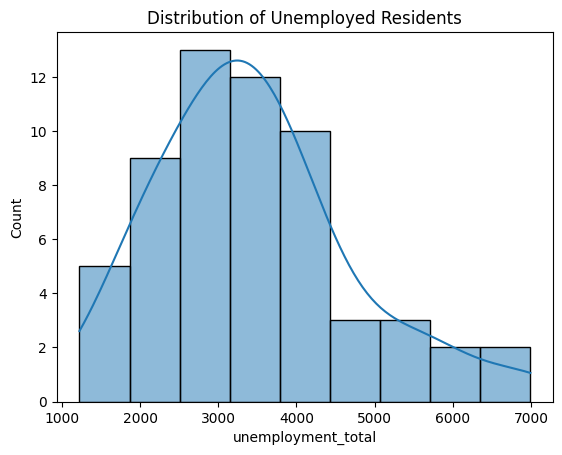

In [ ]:
# Visualise the distribution of unemployment total using a histogram

sns.histplot(unemployment_clean['unemployment_total'], kde=True) # Creates a histogram to show the distribution of unemployment levels.
# Overlay a Kernel Density Estimate (KDE) curve to show the data's probability density
plt.title('Distribution of Unemployed Residents') # Add a title for better readability
plt.show() # Display the final plot


**1.4 Exploring Transport Mode data**

In [ ]:
# Load in transport mode data
modes_df = pd.read_csv("transport.csv")

In [ ]:
# To verify the files were loaded correctly, display the first few rows:
print(modes_df.head(5))

  2001 super output areas - middle layer   mnemonic  \
0                                    NaN        NaN   
1                         Manchester 001  E02001045   
2                         Manchester 002  E02001046   
3                         Manchester 003  E02001047   
4                         Manchester 004  E02001048   

   All people aged 16 to 74 in employment  Work mainly at or from home  \
0                                     NaN                          NaN   
1                                   100.0                          6.9   
2                                   100.0                          6.2   
3                                   100.0                          6.6   
4                                   100.0                          7.2   

   Underground, metro, light rail, tram  Train  Bus, minibus or coach  \
0                                   NaN    NaN                    NaN   
1                                   2.4    0.4                   17.9   
2    

In [ ]:
# Print column names
print(modes_df.columns)

Index(['2001 super output areas - middle layer', 'mnemonic',
       'All people aged 16 to 74 in employment', 'Work mainly at or from home',
       'Underground, metro, light rail, tram', 'Train',
       'Bus, minibus or coach', 'Motorcycle, scooter or moped',
       'Driving a car or van', 'Passenger in a car or van', 'Taxi or minicab',
       'Bicycle', 'On foot', 'Other'],
      dtype='object')


In [ ]:
# Understand distribution of employment data
print(modes_df.describe())

       All people aged 16 to 74 in employment  Work mainly at or from home  \
count                                    53.0                    53.000000   
mean                                    100.0                     6.483019   
std                                       0.0                     0.942936   
min                                     100.0                     4.100000   
25%                                     100.0                     5.900000   
50%                                     100.0                     6.500000   
75%                                     100.0                     7.100000   
max                                     100.0                     8.500000   

       Underground, metro, light rail, tram      Train  Bus, minibus or coach  \
count                             53.000000  53.000000              53.000000   
mean                               1.290566   1.350943              22.720755   
std                                1.821587   0.878071

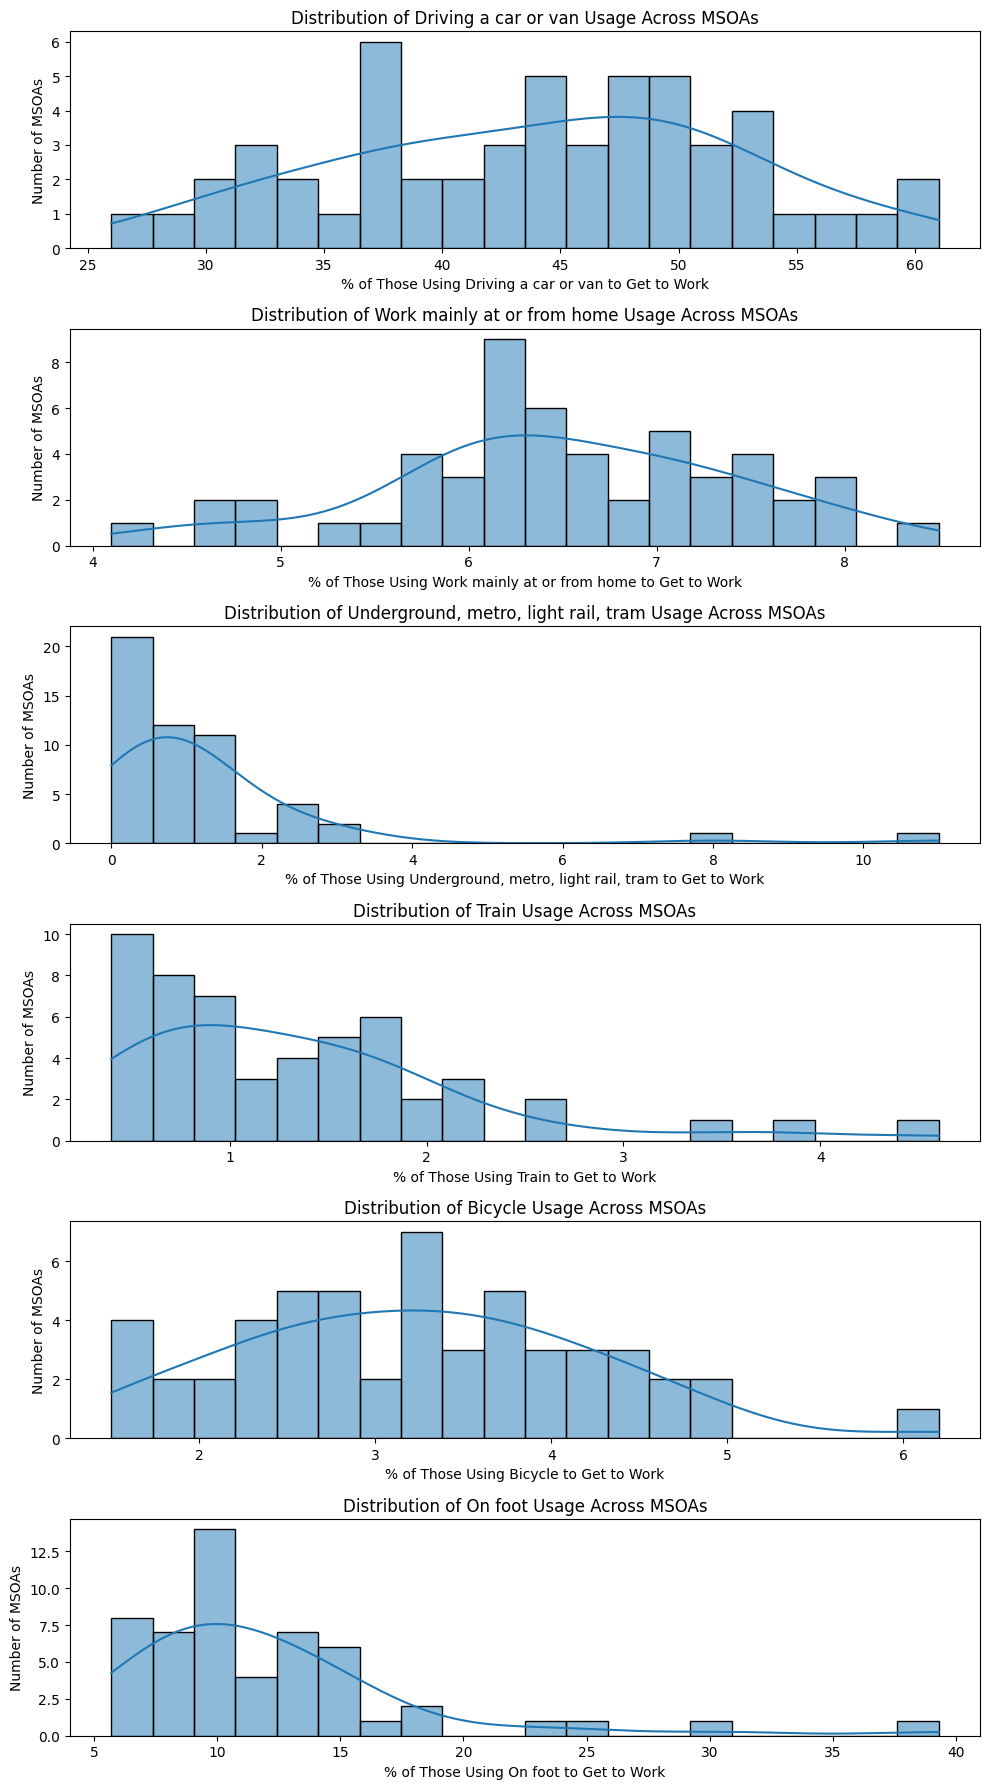

In [ ]:
# Histogram to show the distribution of the percentage of residents using different transport modes within each MSOA

# List of transport modes to be visualised
transport_modes = [
    "Driving a car or van",
    "Work mainly at or from home",
    "Underground, metro, light rail, tram",
    "Train",
    "Bicycle",
    "On foot"
]

# Set up subplots with the number of rows equal to the number of transport modes
fig, axes = plt.subplots(nrows=len(transport_modes), figsize=(10, 18))

# Loop through each mode and plot its histogram
for i, mode in enumerate(transport_modes):
    sns.histplot(modes_df[mode], bins=20, kde=True, edgecolor='black', ax=axes[i])

    axes[i].set_xlabel(f"% of Those Using {mode} to Get to Work")  # Adds x-axis label
    axes[i].set_ylabel("Number of MSOAs")  # Adds y-axis label representing count of MSOAs
    axes[i].set_title(f"Distribution of {mode} Usage Across MSOAs")  # Sets title for each subplot

# Adjusts layout to prevent overlap between subplots
plt.tight_layout()

# Displays the final figure with all histograms
plt.show()



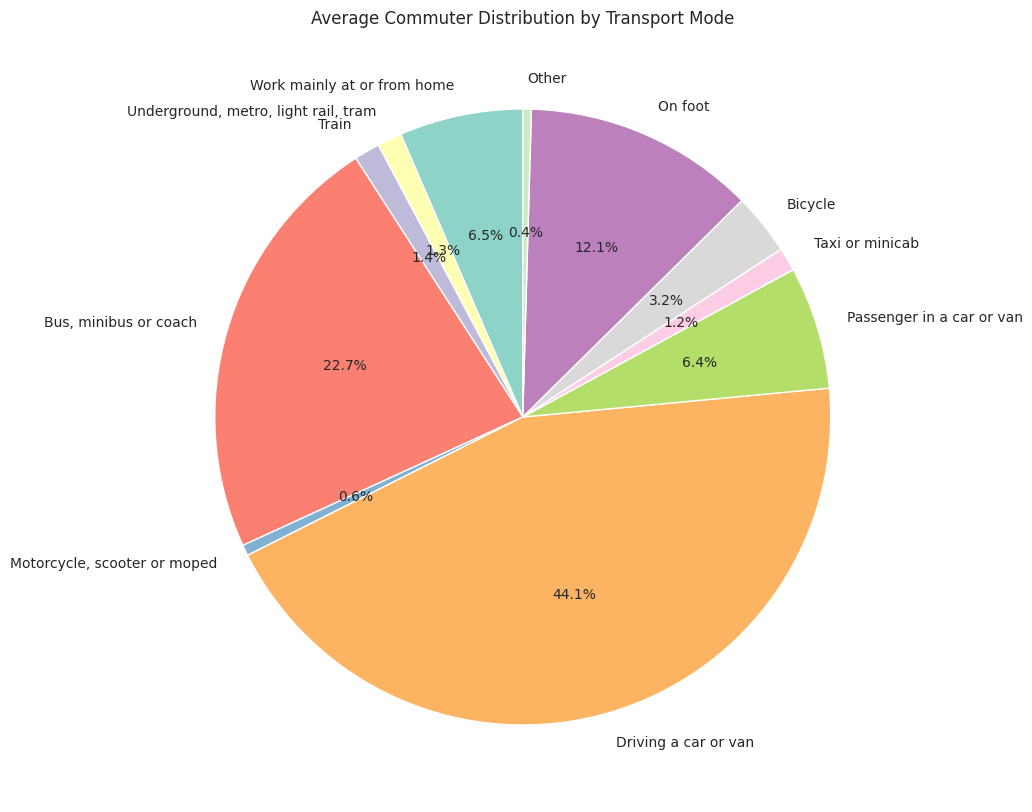

In [183]:
# Make a Pie Chart displaying average values of modes of transport to get to work across MSOAs in Manchester

# Define the categories to average
categories = [
    "Work mainly at or from home",
    "Underground, metro, light rail, tram",
    "Train", "Bus, minibus or coach",
    "Motorcycle, scooter or moped",
    "Driving a car or van", "Passenger in a car or van",
    "Taxi or minicab", "Bicycle", "On foot", "Other"
]

# Ensure only numeric data is used for averaging
modes_df_numeric = modes_df[categories].apply(pd.to_numeric, errors="coerce")
# Converts relevant columns to numeric format, replacing non-numeric values with NaN

# Calculate the average for each category
category_averages = modes_df_numeric.mean()

# Create a pie chart
plt.figure(figsize=(10, 10))  # Define plot size

plt.pie(
    category_averages,  # Data values for each commuting mode
    labels=category_averages.index,  # Label each slice based on transport modes
    autopct="%1.1f%%",  # Show percentage values on slices (formatted to 1 decimal place)
    colors=plt.get_cmap("Set3").colors,  # Use 'Set3' colormap for diverse colors
    startangle=90  # Rotate pie chart so first slice starts at the top
)

plt.title("Average Commuter Distribution by Transport Mode")  # Add appropriate title

plt.show()  # Display the final pie chart


**1.5 Exploring Distance travelled to work data**

In [ ]:
# Load in distance travelled to work data
distance_df = pd.read_csv("distancework.csv")

In [ ]:
# To verify the files were loaded correctly, display the first few rows:
print(distance_df.head(5))

  2021 super output area - middle layer   mnemonic  \
0                                   NaN        NaN   
1                        Manchester 001  E02001045   
2                        Manchester 002  E02001046   
3                        Manchester 003  E02001047   
4                        Manchester 004  E02001048   

   Total: All usual residents aged 16 years and over in employment the week before the census  \
0                                                NaN                                            
1                                             3303.0                                            
2                                             4673.0                                            
3                                             4300.0                                            
4                                             3682.0                                            

       %  Less than 2km   %.1  2km to less than 5km   %.2  \
0    NaN            NaN   NaN  

In [ ]:
# Print column names
print(distance_df.columns)

Index(['2021 super output area - middle layer', 'mnemonic',
       'Total: All usual residents aged 16 years and over in employment the week before the census',
       '%', 'Less than 2km', '%.1', '2km to less than 5km', '%.2',
       '5km to less than 10km', '%.3', '10km to less than 20km', '%.4',
       '20km to less than 30km', '%.5', '30km to less than 40km', '%.6',
       '40km to less than 60km', '%.7', '60km and over', '%.8',
       'Works mainly from home', '%.9',
       'Works mainly at an offshore installation, in no fixed place, or outside the UK',
       '%.10'],
      dtype='object')


In [ ]:
# Understand distribution of distance to work data
print(distance_df.describe())

       Total: All usual residents aged 16 years and over in employment the week before the census  \
count                                          59.000000                                            
mean                                         3970.559322                                            
std                                           677.733730                                            
min                                          2418.000000                                            
25%                                          3643.000000                                            
50%                                          3865.000000                                            
75%                                          4304.500000                                            
max                                          6070.000000                                            

           %  Less than 2km        %.1  2km to less than 5km        %.2  \
count   59.0   

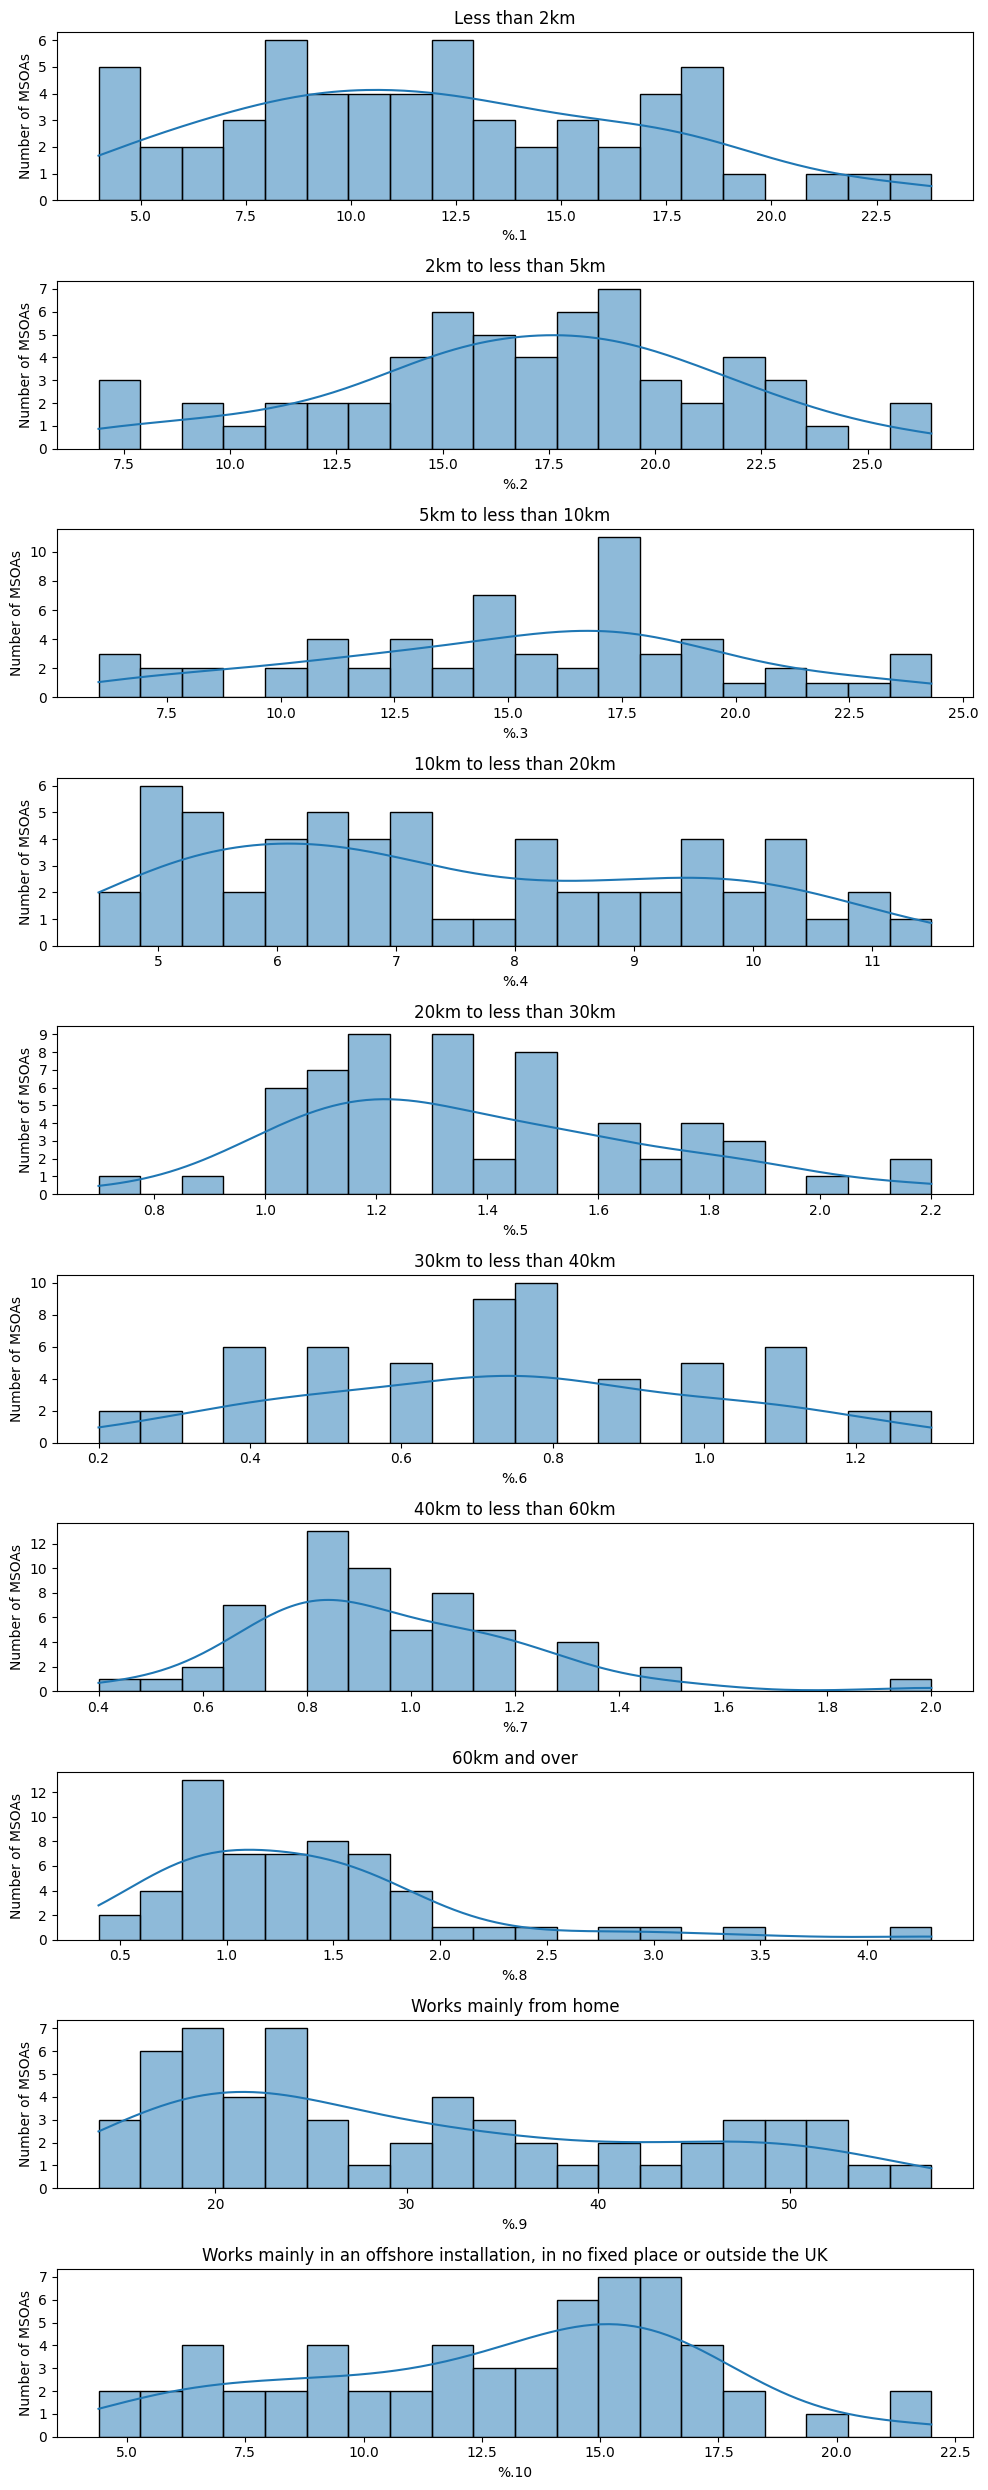

In [ ]:
# Make a histogram showing the distribution of travel distances to work for MSOAs in Manchester

# Import any extra packages required
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# List of relevant columns for histogram plotting. We want to use % rather than the raw data as we have it.
distance_columns = [
    "%.1", "%.2", "%.3", "%.4", "%.5", "%.6", "%.7", "%.8", "%.9", "%.10"
]

# Titles for each plot reflecting distance categories
titles = [
    "Less than 2km", "2km to less than 5km", "5km to less than 10km",
    "10km to less than 20km", "20km to less than 30km", "30km to less than 40km",
    "40km to less than 60km", "60km and over", "Works mainly from home",
    "Works mainly in an offshore installation, in no fixed place or outside the UK"
]

fig, axes = plt.subplots(nrows=len(distance_columns), figsize=(10, 25))

# Loop through each column in the dataset and apply customization for histogram plots
for i, (column, title) in enumerate(zip(distance_columns, titles)):
    # Enumerate through distance_columns and titles simultaneously

    sns.histplot(
        distance_df[column],  # Select the column for visualisation
        bins=20,  # Set number of bins to group data into intervals
        kde=True,  # Overlay a KDE curve
        edgecolor='black',  # Adds borders to histogram bars for better visibility
        ax=axes[i]  # Assigns each histogram to a separate subplot
    )

    axes[i].set_ylabel("Number of MSOAs")  # Label the y-axis consistently for all plots
    axes[i].set_title(title)  # Assigns a clear title to each subplot using its category name

    # Ensure the y-axis displays integer values only
    axes[i].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    # - Uses `MaxNLocator(integer=True)` to prevent decimal y-axis labels
    # - Ensures MSOA counts are displayed as whole numbers (e.g., 1, 2, 3…)

# Adjust layout for better readability and spacing between subplots
plt.tight_layout()

# Display the final set of histogram plots
plt.show()


**Justification of data cleaning and exploration choices**

Using descriptive statistics and histograms to assess variable distributions is a fundamental step in data cleaning, ensuring accuracy before analysis. Descriptive statistics, such as mean, median, and standard deviation, help identify inconsistencies, skewness, and missing values, guiding appropriate imputation or removal strategies (Woods et al., 2023). Histograms further reveal distribution patterns and highlight outliers, which can distort regression models if left unaddressed (Gregg and Moore, 2023). Renaming variables ensures consistency, clarity, and alignment with analysis objectives, reducing ambiguity and enhancing data interpretability (Necula et al., 2024).

**2.0 Statistical Modelling**

Joining the CSV files to the boundary file is a necessary step to undertake to ensure that non-spatial data is correctly linked to geographic regions and polygons. . This integration allows for spatial analysis and visualisation, enabling meaningful insights into how commuting patterns vary across different MSOAs in Manchester.


In [130]:
# Steps to perform a spatial join

# Check columns to identify which one to use as spatial join
print(mancboundaries.columns)
print(distance_df.columns)
print(unemployment_clean.columns)
print(modes_df.columns)

Index(['code', 'name', 'label', 'geometry', 'Bus_Stop_Count_x',
       'Bus_Stop_Count_y', 'Bus_Stop_Count'],
      dtype='object')
Index(['2021 super output area - middle layer', 'mnemonic',
       'Total: All usual residents aged 16 years and over in employment the week before the census',
       '%', 'Less than 2km', '%.1', '2km to less than 5km', '%.2',
       '5km to less than 10km', '%.3', '10km to less than 20km', '%.4',
       '20km to less than 30km', '%.5', '30km to less than 40km', '%.6',
       '40km to less than 60km', '%.7', '60km and over', '%.8',
       'Works mainly from home', '%.9',
       'Works mainly at an offshore installation, in no fixed place, or outside the UK',
       '%.10'],
      dtype='object')
Index(['2021 super output area - middle layer', 'unemployment_total',
       'mnemonic'],
      dtype='object')
Index(['2001 super output areas - middle layer', 'mnemonic',
       'All people aged 16 to 74 in employment', 'Work mainly at or from home',
       'Und

In [131]:
# Merge all datasets on the 'mnemonic' column (from data) and 'code' column (from shapefile)
gdf = mancboundaries.merge(distance_df, left_on="code", right_on="mnemonic", how="left")
gdf = gdf.merge(unemployment_clean, left_on="code", right_on="mnemonic", how="left")
gdf = gdf.merge(modes_df, left_on="code", right_on="mnemonic", how="left")

# Check the result
print(gdf.head())

# Save the merged file as a new shapefile
gdf.to_file("merged_data.shp")

        code            name               label  \
0  E02001045  Manchester 001  E08000003E02001045   
1  E02001046  Manchester 002  E08000003E02001046   
2  E02001047  Manchester 003  E08000003E02001047   
3  E02001048  Manchester 004  E08000003E02001048   
4  E02001049  Manchester 005  E08000003E02001049   

                                            geometry  Bus_Stop_Count_x  \
0  POLYGON ((385672.188 405140, 385671.004 405128...                59   
1  POLYGON ((386609.567 403992.776, 386626.093 40...                73   
2  POLYGON ((387164.548 403916.823, 387167.731 40...                80   
3  POLYGON ((384278.241 404726.991, 384292.688 40...                56   
4  POLYGON ((388361.484 402967.194, 388362 402967...                71   

   Bus_Stop_Count_y  Bus_Stop_Count 2021 super output area - middle layer_x  \
0                59              59                          Manchester 001   
1                73              73                          Manchester 002   
2    

<ipython-input-131-49adcced26bd>:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("merged_data.shp")
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Bus_Stop_Count_x' to 'Bus_Stop_C'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Bus_Stop_Count_y' to 'Bus_Stop_1'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Bus_Stop_Count' to 'Bus_Stop_2'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: '2021 super output area - middle layer_x' to '2021 super'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Total: All usual residents aged 16 years and over in employment the wee

In [132]:
# Print column names of new merged dataset
print(gdf.columns)

Index(['code', 'name', 'label', 'geometry', 'Bus_Stop_Count_x',
       'Bus_Stop_Count_y', 'Bus_Stop_Count',
       '2021 super output area - middle layer_x', 'mnemonic_x',
       'Total: All usual residents aged 16 years and over in employment the week before the census',
       '%', 'Less than 2km', '%.1', '2km to less than 5km', '%.2',
       '5km to less than 10km', '%.3', '10km to less than 20km', '%.4',
       '20km to less than 30km', '%.5', '30km to less than 40km', '%.6',
       '40km to less than 60km', '%.7', '60km and over', '%.8',
       'Works mainly from home', '%.9',
       'Works mainly at an offshore installation, in no fixed place, or outside the UK',
       '%.10', '2021 super output area - middle layer_y', 'unemployment_total',
       'mnemonic_y', '2001 super output areas - middle layer', 'mnemonic',
       'All people aged 16 to 74 in employment', 'Work mainly at or from home',
       'Underground, metro, light rail, tram', 'Train',
       'Bus, minibus or coach'

A Multiple Linear Regression model was chosen as the choice of statistical modelling. This is justified because it allows for a quantitative assessment of how multiple commuting factors impact unemployment rates. It accounts for multiple predictors simultaneously, preventing misleading single-variable conclusions. The model helps identify statistically significant factors, such as commute distance or remote work, that influence employment levels. Additionally, regression provides predictive insights, enabling policymakers to forecast unemployment trends based on commuting behavior. Since unemployment is a continuous variable, regression is a suitable method for analysing its variation across different commuting patterns (Luskin, 2008).


In [133]:
# Import required packages
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import numpy as np  # Import numpy for isinf and isnan checks

# Define predictors (independent variables) including 'Bus_Stop_Count'
X = gdf[['Less than 2km', '2km to less than 5km', '5km to less than 10km',
         '10km to less than 20km', '20km to less than 30km', '30km to less than 40km',
         '40km to less than 60km', '60km and over', 'Works mainly from home',
         'Train', 'Bus, minibus or coach', 'Driving a car or van', 'Bicycle', 'On foot',
         'Bus_Stop_Count']]  # Added Bus_Stop_Count

# Define target variable (dependent variable)
y = gdf['unemployment_total']

# Check for and replace infinite or NaN values in X and y
X = X.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
X = X.fillna(X.mean())  # Fill NaN values with the column mean
y = y.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
y = y.fillna(y.mean())  # Fill NaN values with the column mean

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add constant to predictors
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit OLS regression model
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = model.rsquared

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")



                            OLS Regression Results                            
Dep. Variable:     unemployment_total   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     12.67
Date:                Mon, 12 May 2025   Prob (F-statistic):           6.40e-09
Time:                        12:01:30   Log-Likelihood:                -340.32
No. Observations:                  45   AIC:                             712.6
Df Residuals:                      29   BIC:                             741.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   3699

This OLS regression model demonstrates a strong overall fit, explaining around 86.8% of the variation in unemployment totals, which suggests that the included commuting-related variables are meaningful predictors. Notably, areas with higher proportions of people commuting less than 2km and 60km or more tend to have higher unemployment totals, possibly reflecting urban concentrations or limited local job opportunities.

More people working from home is associated with lower unemployment, suggesting benefits from remote work opportunities. Although bus stop count was not statistically significant, its negative coefficient implies a potential relationship where greater public transport accessibility could be linked to lower unemployment—possibly by improving access to jobs. While not definitive in this model, this trend supports the idea that well-connected areas may have better employment outcomes. Further analysis with more focused data on transport infrastructure could help clarify this relationship.


**3.0 Non-spatial Visualisation**

This grouped bar chart is designed to clearly illustrate the relationship between commuting distances and unemployment levels. By using distinct colors and grouping by unemployment levels, the visualisation allows for easy comparison of travel patterns across different employment categories (Garcia-Mila et al., 2014). A colourblind-friendly palette ensures accessibility, making the graph readable for all audiences (Rocchini et al., 2023). To further improve clarity, rotated labels and a structured legend have been included, ensuring users can quickly interpret the data. This visualisation aims to provide an intuitive yet detailed representation of mobility trends

<Figure size 1200x600 with 0 Axes>

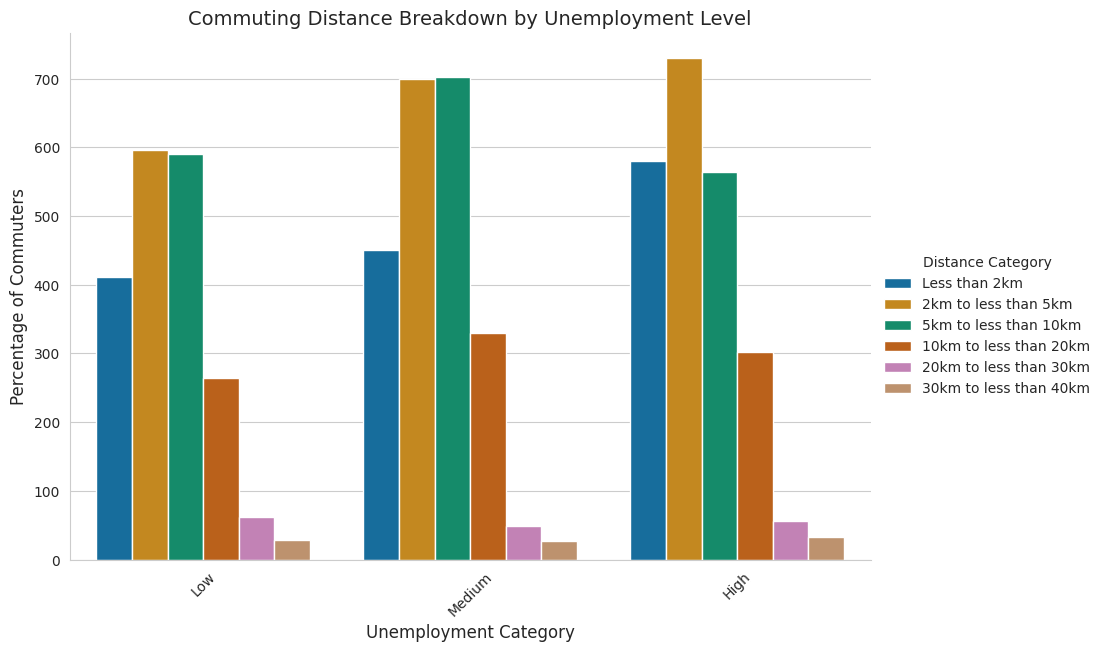

In [185]:
# Bar Chart for Commuting Distance Breakdown

# Define unemployment categories based on total unemployment levels
df = gdf.copy()  # Create a copy of the GeoDataFrame to avoid modifying the original dataset

df["Unemployment Category"] = pd.qcut(
    df["unemployment_total"],  # Column containing total unemployment values per MSOA
    q=3,  # Divides the data into 3 quantiles to create Low, Medium, and High categories
    labels=["Low", "Medium", "High"]  # Assigns categorical labels for easier interpretation
)

# Define commuting distance categories
distance_categories = [
    "Less than 2km", "2km to less than 5km", "5km to less than 10km",
    "10km to less than 20km", "20km to less than 30km", "30km to less than 40km"
]

# Group by unemployment category and calculate mean travel distances
df_grouped_distance = df.groupby("Unemployment Category", observed=False)[distance_categories].mean().reset_index()
# Groups the data by Low, Medium, High unemployment categories and calculates the average percentage of commuters for each distance range.

# Reshape the data for visualisation using "melt"
df_distance_melted = df_grouped_distance.melt(
    id_vars=["Unemployment Category"],  # Keeps the unemployment category as an identifier
    var_name="Distance Category",  # Stores distance range names in one column
    value_name="Percentage"  # Stores the corresponding average percentage of commuters
)

# Create grouped bar chart
plt.figure(figsize=(12, 6))  # Define figure size for better readability
sns.set_style("whitegrid")  # Use a clean, readable background for the plot

sns.catplot(
    data=df_distance_melted,  # Use melted data for visualisation
    x="Unemployment Category",  # X-axis represents employment category (Low, Medium, High)
    y="Percentage",  # Y-axis represents the percentage of commuters in each distance range
    hue="Distance Category",  # Different commuting distances are shown as separate colors
    kind="bar",  # Creates a grouped bar chart
    height=6, aspect=1.5,  # Adjusts chart size for better visibility
    palette="colorblind"  # Ensures accessibility for colorblind audiences
)

# Customise labels and titles
plt.title("Commuting Distance Breakdown by Unemployment Level", fontsize=14)  # Title for context
plt.xlabel("Unemployment Category", fontsize=12)  # X-axis label
plt.ylabel("Percentage of Commuters", fontsize=12)  # Y-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the final visualisation
plt.show()



The bar chart effectively highlights key variations in travel behavior across unemployment levels. By using aggregated data for unemployment levels, it reveals patterns in commuting distances: such as in those MSOAs with higher unemployment levels,  individuals tend to travel shorter or longer distances compared to lower unemployment groups. The structured legend and label orientation enhance readability, ensuring that the differences in each category are easy to interpret. Overall, this visualisation makes it possible to derive meaningful insights into mobility trends, supporting a deeper understanding of public transport accessibility and employment outcomes.

**5.0 Spatial Visualisation**

Using choropleth maps with four subplots allows for direct comparisons between spatial distributions, making patterns in unemployment rates, transport accessibility, and commuting distances more interpretable. This structure ensures that relationships between variables—such as public transport usage and employment levels—are visually evident, aiding in policy decision. Choropleth maps are effective in representing variations across geographic regions, helping to highlight disparities in accessibility and socioeconomic factors (Crampton, 2004). Additionally, placing multiple maps side by side enables a standardised spatial reference, ensuring users can easily spot correlations without switching between separate visualisations.

In [158]:
# Firstly add up the relevant columns to compute % using public transport

# Print all columns
print(gdf.columns)

Index(['code', 'name', 'label', 'geometry', 'Bus_Stop_Count_x',
       'Bus_Stop_Count_y', 'Bus_Stop_Count',
       '2021 super output area - middle layer_x', 'mnemonic_x',
       'Total: All usual residents aged 16 years and over in employment the week before the census',
       '%', 'Less than 2km', '%.1', '2km to less than 5km', '%.2',
       '5km to less than 10km', '%.3', '10km to less than 20km', '%.4',
       '20km to less than 30km', '%.5', '30km to less than 40km', '%.6',
       '40km to less than 60km', '%.7', '60km and over', '%.8',
       'Works mainly from home', '%.9',
       'Works mainly at an offshore installation, in no fixed place, or outside the UK',
       '%.10', '2021 super output area - middle layer_y', 'unemployment_total',
       'mnemonic_y', '2001 super output areas - middle layer', 'mnemonic',
       'All people aged 16 to 74 in employment', 'Work mainly at or from home',
       'Underground, metro, light rail, tram', 'Train',
       'Bus, minibus or coach'

In [164]:
# Create a new column for total public transport usage
gdf["Public_Transport_Percentage"] = (
    gdf["Underground, metro, light rail, tram"] +
    gdf["Train"] + gdf["Bus, minibus or coach"]
)

# Display the first few rows to verify
print(gdf[["code", "Public_Transport_Percentage"]].head(5))


        code  Public_Transport_Percentage
0  E02001045                         20.7
1  E02001046                         24.5
2  E02001047                         22.3
3  E02001048                         21.9
4  E02001049                         19.2


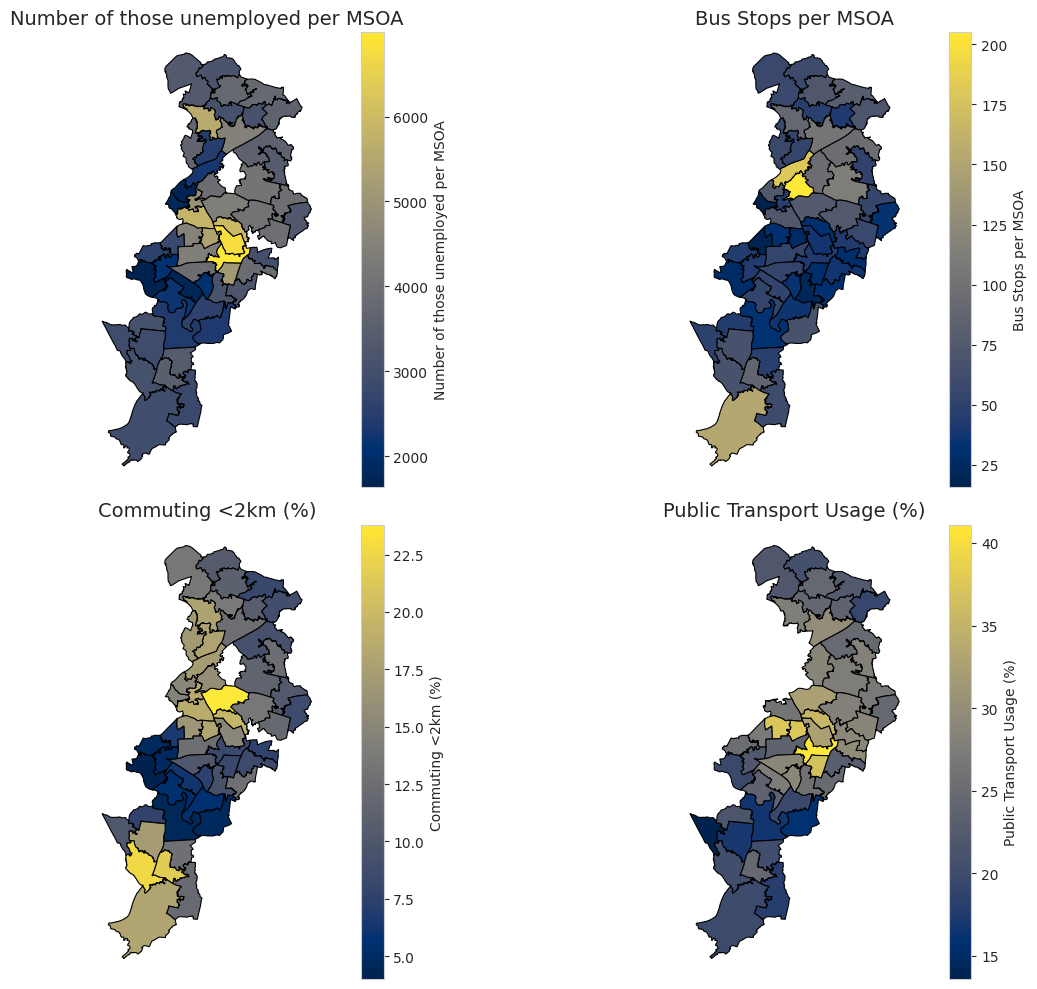

In [173]:
# Make the Chloropleth Maps

# Define figure size and create 4 subplots (arranged in 2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Creates a figure with 4 subplots for side-by-side comparisons

# Define datasets (columns from gdf) to visualise in choropleth maps
columns = ["unemployment_total", "Bus_Stop_Count",
           "%.1", "Public_Transport_Percentage"]  # Each column represents a different variable for mapping

# Define corresponding titles for each subplot
titles = ["Number of those unemployed per MSOA", "Bus Stops per MSOA",
          "Commuting <2km (%)", "Public Transport Usage (%)"]  # Titles describe what each map represents

# Define colourmaps for accessibility (cividis is colorblind-friendly)
colormaps = ["cividis", "cividis", "cividis", "cividis"]  # Ensures consistency & readability

# Loop through each subplot to create individual choropleth maps
for i, ax in enumerate(axes.flatten()):  # Iterates over each subplot to plot maps dynamically
    map_plot = gdf.plot(column=columns[i], cmap=colormaps[i], linewidth=0.8, edgecolor="black", ax=ax)
    # Plots choropleth maps using geopandas, applying specified colormaps and column data

    ax.set_title(titles[i], fontsize=14)  # Sets a title for each subplot
    ax.axis("off")  # Removes axis labels and tick marks for clean visualisation

    # Add colourbar to represent data values for each map
    fig.colorbar(map_plot.collections[0], ax=ax, label=titles[i])  # Adds a colour scale to indicate intensity levels

# Adjust layout for better readability and spacing between subplots
plt.tight_layout()  # Ensures subplots fit neatly within the figure without overlapping elements

# Display the final visualisation
plt.show()  # Renders the figure with 4 choropleth maps



These four choropleth maps for Manchester MSOAs reveal intriguing spatial relationships between unemployment and commuting behaviours. The central areas stand out, exhibiting the highest rates of unemployment alongside the greatest density of bus stops and the highest public transport usage. This convergence suggests a complex interplay where potentially greater accessibility coincides with significant economic need or heightened competition for available jobs.

Furthermore, the maps indicate that areas with a larger proportion of short-distance commuters (under 2km) are predominantly located in central and southern MSOAs. This pattern could be indicative of urban density, where residents live closer to employment opportunities, or potentially reflect limitations in job mobility requiring longer commutes.

The observed spatial alignment of high unemployment with robust public transport infrastructure reinforces the regression analysis findings. Factors such as working from home and the prevalence of long commutes, as identified statistically, appear to have a tangible spatial dimension. This suggests that while public transport access is generally considered an advantage, its concentration in areas of high unemployment warrants further investigation into the underlying socio-economic dynamics.

Collectively, these four visualisations offer a comprehensive spatial perspective on the relationship between public transport accessibility and employment rates across Manchester. By mapping unemployment disparities, bus stop density as a proxy for accessibility, the prevalence of short-distance commuting as an indicator of local job markets, and overall public transport usage, these subplots provide a valuable foundation for evidence-based urban planning and policy discussions aimed at addressing the observed spatial patterns of economic disadvantage and mobility.

**Reference List**

Crampton, J. 2004. GIS and geographic governance: Reconstructing the choropleth map. Cartographica. 39(1),pp.41–53.


Garcia-Mila, M., Marti, E., Gilabert, S. and Castells, M. 2014. Fifth through eighth grade students’ difficulties in constructing bar graphs: Data organization, data aggregation, and integration of a second variable. Mathematical Thinking and Learning. 16(3),pp.201–233.


Gregg, J.T. and Moore, J.H. 2023. STAR_outliers: A python package that separates univariate outliers from non-normal distributions. BioData Mining. 16(1).


Luskin, R.C. 2008. Wouldn’t it be nice …? the automatic unbiasedness of OLS (and GLS). Political Analysis. 16(3),pp.345–349.


Necula, S.-C., Fotache, D. and Rieder, E. 2024. Assessing the impact of artificial intelligence tools on employee productivity: Insights from a comprehensive survey analysis. Electronics. 13(18),p.3758.


OYANA, T.J. 2023. Spatial analysis with r: Statistics, visualization, and computational methods. S.l.: CRC PRESS.


Rocchini, D., Nowosad, J., D’Introno, R., Chieffallo, L., Bacaro, G., Gatti, R.C., Foody, G.M., Furrer, R., Gábor, L., Malavasi, M., Marcantonio, M., Marchetto, E., Moudrý, V., Ricotta, C., Šímová, P., Torresani, M. and Thouverai, E. 2023. Scientific maps should reach everyone: The cblindplot R package to let colour blind people visualise spatial patterns. Ecological Informatics. 76,p.102045.


Woods, A.D., Gerasimova, D., Van Dusen, B., Nissen, J., Bainter, S., Uzdavines, A., Davis-Kean, P., Halvorson, M.A., King, K.M., Logan, J.A., Xu, M., Vasilev, M.R., Clay, J.M., Moreau, D., Joyal-Desmarais, K., Cruz, R.A., Brown, D.M., Schmidt, K. and Elsherif, M.M. 2021. Best practices for addressing missing data through multiple imputation.



Contains Transport for Greater Manchester data. Contains OS data © Crown copyright and database right 2024.
